# TRY 3

In [1]:
import os
import pathlib
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [2]:
# Define paths
pascal_voc = pathlib.Path('./data/VOC2012_train_val')
image_dir = pascal_voc / 'JPEGImages'
label_dir = pascal_voc / 'SegmentationClass'
split_dir = pascal_voc / 'ImageSets' / 'Segmentation'

# Read image IDs from trainval.txt
with open(split_dir / 'trainval.txt', 'r') as f:
    image_ids = [line.strip() for line in f]

# Class names and colormap (RGB values for each class)
classes = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", 
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

voc_colormap = [
    (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
]

In [3]:
def rgb_to_mask(label_rgb, colormap):
    h, w = label_rgb.shape[:2]
    mask = np.full((h, w), 255, dtype=np.uint8)  # Default to void (255)
    for idx, color in enumerate(colormap):
        match = np.all(label_rgb == np.array(color).reshape(1, 1, 3), axis=2)
        mask[match] = idx
    return mask

In [4]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_ids, colormap, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_ids = image_ids
        self.colormap = colormap
        self.transform = transform

        # Add basic transforms for consistent size
        self.basic_transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
        ])
        self.label_transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),

        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.jpg')
        label_path = os.path.join(self.label_dir, image_id + '.png')

        # Load image and label

        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('RGB')
        label = np.array(label)
        label = rgb_to_mask(label, self.colormap)
        label = Image.fromarray(label)  # Convert to PIL for transforms

        # Apply basic transforms first (resize to consistent size)

        image = self.basic_transform(image)
        label = self.label_transform(label)

        # Apply additional transformations if specified
        if self.transform:
            image, label = self.transform(image, label)

        # Convert to tensor and normalize image

        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        label = torch.from_numpy(np.array(label)).long()

        return image, label


In [54]:
########################################################
class VOCDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_ids, colormap, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_ids = image_ids
        self.colormap = colormap
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.jpg')
        label_path = os.path.join(self.label_dir, image_id + '.png')

        # Load image and label
        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('RGB')
        label = np.array(label)
        label = rgb_to_mask(label, self.colormap)
        label = Image.fromarray(label)  # Convert to PIL for transforms

        # Apply transformations
        if self.transform:
            image, label = self.transform(image, label)

        # Convert to tensor and normalize image
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        label = torch.from_numpy(np.array(label)).long()

        return image, label

In [5]:
class AugmentTransform:
    def __call__(self, image, label):
        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random rotation (-10 to 10 degrees)
        angle = random.uniform(-10, 10)
        image = TF.rotate(image, angle)
        label = TF.rotate(label, angle, fill=255)  # Fill void with 255

        # Resize and random crop
        resize_size = (256, 256)
        image = TF.resize(image, resize_size, TF.InterpolationMode.BILINEAR)
        label = TF.resize(label, resize_size, TF.InterpolationMode.NEAREST)

        # Random crop to 224x224
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
        image = TF.crop(image, i, j, h, w)
        label = TF.crop(label, i, j, h, w)

        return image, label

In [6]:
# Initialize dataset with augmentations
dataset = VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=image_ids,
    colormap=voc_colormap,
    transform=AugmentTransform()
)



# Create DataLoader with minimal worker configuration for stability
dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False  # Disable pin_memory for now

)
try:
    # Test the dataloader with a single batch
    images, labels = next(iter(dataloader))
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')
except Exception as e:
    print(f"Error loading data: {str(e)}")


Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 224, 224])


In [7]:
# Check a sample batch
images, labels = next(iter(dataloader))
print(f'Image batch shape: {images.shape}')
print(f'Label batch shape: {labels.shape}')
print(f'Unique label values: {torch.unique(labels)}')

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 224, 224])
Unique label values: tensor([  0,   1,   6,   8,  10,  13,  15, 255])


In [14]:
# Collect all unique class indices across the entire dataset
all_labels = []
for _, labels in dataloader:
    all_labels.append(labels.unique())

# Combine results
all_unique = torch.cat(all_labels).unique()
print("All unique class indices in the dataset:", all_unique)

# Check if all 0-20 are present
missing_classes = [i for i in range(21) if i not in all_unique]
if missing_classes:
    print("Missing classes:", missing_classes)
else:
    print("All 21 classes are present!")

All unique class indices in the dataset: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20, 255])
All 21 classes are present!


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34

# ----------------------
# 1. Define DoubleConv
# ----------------------
class DoubleConv(nn.Module):
    """(Convolution => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# ----------------------
# 2. Define AttentionGate
# ----------------------
class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels):
        super().__init__()
        self.W_g = nn.Conv2d(gating_channels, in_channels, kernel_size=1)
        self.W_x = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.psi = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # Resize g (encoder feature) to match x's spatial dimensions
        if g.shape[2:] != x.shape[2:]:
            g = F.interpolate(g, size=x.shape[2:], mode='bilinear', align_corners=True)
        g_conv = self.W_g(g)
        x_conv = self.W_x(x)
        combined = self.relu(g_conv + x_conv)
        attention = self.sigmoid(self.psi(combined))
        return x * attention

# ----------------------
# 3. Define CustomUNet (Fixed)
# ----------------------
class CustomUNet(nn.Module):
    def __init__(self, n_classes=21):
        super().__init__()
        # Encoder (ResNet-34)
        resnet = resnet34(pretrained=True)
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder with attention gates
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn1 = AttentionGate(256, 256)
        self.decoder1 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attn2 = AttentionGate(128, 128)
        self.decoder2 = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attn3 = AttentionGate(64, 64)
        self.decoder3 = DoubleConv(128, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.attn4 = AttentionGate(64, 64)
        self.decoder4 = DoubleConv(128, 64)

        # Final output
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)    # (64, 56, 56)
        e2 = self.encoder2(e1)   # (64, 56, 56)
        e3 = self.encoder3(e2)   # (128, 28, 28)
        e4 = self.encoder4(e3)   # (256, 14, 14)
        e5 = self.encoder5(e4)   # (512, 7, 7)

        # Decoder
        d1 = self.up1(e5)        # (256, 14, 14)
        a1 = self.attn1(d1, e4)  # (256, 14, 14)
        d1 = torch.cat([a1, e4], dim=1)  # (512, 14, 14)
        d1 = self.decoder1(d1)   # (256, 14, 14)

        d2 = self.up2(d1)        # (128, 28, 28)
        a2 = self.attn2(d2, e3)  # (128, 28, 28)
        d2 = torch.cat([a2, e3], dim=1)  # (256, 28, 28)
        d2 = self.decoder2(d2)   # (128, 28, 28)

        d3 = self.up3(d2)        # (64, 56, 56)
        a3 = self.attn3(d3, e2)  # (64, 56, 56)
        d3 = torch.cat([a3, e2], dim=1)  # (128, 56, 56)
        d3 = self.decoder3(d3)   # (64, 56, 56)

        d4 = self.up4(d3)        # (64, 112, 112)
        
        # Upsample e1 to match d4's spatial size
        e1_upsampled = F.interpolate(e1, size=d4.shape[2:], mode='bilinear', align_corners=True)
        a4 = self.attn4(d4, e1_upsampled)  # (64, 112, 112)
        d4 = torch.cat([a4, e1_upsampled], dim=1)  # (128, 112, 112)
        d4 = self.decoder4(d4)   # (64, 112, 112)

        # Final upsampling to input size (224x224)
        out = self.final_upsample(d4)  # (64, 224, 224)
        return self.out(out)      # (n_classes, 224, 224)

In [9]:
# Test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomUNet(n_classes=21).to(device)
dummy_input = torch.randn(8, 3, 224, 224).to(device)
output = model(dummy_input)
print(output.shape)  # Should output: torch.Size([8, 21, 224, 224])

c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 21, 224, 224])


In [10]:
import numpy as np
import torch

def compute_metrics(outputs, labels):
    # Ensure outputs and labels are on the same device
    outputs = outputs.detach()
    labels = labels.detach()

    # Ignore void class (255)
    mask = (labels != 255)
    outputs = outputs.argmax(dim=1)  # Convert logits to class indices (B, H, W)
    outputs = outputs[mask]
    labels = labels[mask]

    # Handle empty tensors (if all pixels are void)
    if outputs.numel() == 0:
        return torch.tensor(0.0).to(outputs.device), torch.tensor(0.0).to(outputs.device)

    # Pixel accuracy
    acc = (outputs == labels).float().mean()

    # Calculate IoU for each class (21 classes for VOC)
    ious = []
    n_classes = 21  # Fixed for Pascal VOC
    for cls in range(n_classes):
        pred_cls = (outputs == cls)
        target_cls = (labels == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        if union == 0:
            ious.append(float('nan'))  # Skip classes with no ground truth
        else:
            ious.append((intersection / union).item())

    # Compute mean IoU, ignoring NaN
    miou = np.nanmean(ious) if not np.isnan(ious).all() else 0.0

    return acc, torch.tensor(miou).to(outputs.device)

In [17]:
from sklearn.model_selection import train_test_split

# Split dataset into train and validation
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create datasets with augmentation for training
train_dataset = VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=train_ids,
    colormap=voc_colormap,
    transform=AugmentTransform()  # Apply augmentations
)

val_dataset = VOCDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_ids=val_ids,
    colormap=voc_colormap,
    transform=None  # No augmentation for validation
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0  # Set to 0 if multiprocessing causes issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

In [18]:
import torch.optim as optim
from tqdm import tqdm

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomUNet(n_classes=21).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    running_miou = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)  # Already 224x224 from dataset transforms
        
        # Forward pass (no label resizing needed)
        outputs = model(images)  # Output shape: (B, 21, 224, 224)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics
        acc, miou = compute_metrics(outputs, labels)
        running_loss += loss.item()
        running_acc += acc.item()
        running_miou += miou.item()  # Convert tensor to float

    scheduler.step()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    epoch_miou = running_miou / len(train_loader)
    print(f'Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, mIoU={epoch_miou:.4f}')

print("Training complete!")

Epoch 1/10: 100%|██████████| 146/146 [14:55<00:00,  6.13s/it]


Epoch 1: Loss=2.2347, Acc=0.5531, mIoU=0.0597


Epoch 2/10: 100%|██████████| 146/146 [13:25<00:00,  5.52s/it]


Epoch 2: Loss=1.6116, Acc=0.6609, mIoU=0.0885


Epoch 3/10: 100%|██████████| 146/146 [13:55<00:00,  5.72s/it]


Epoch 3: Loss=1.3075, Acc=0.7124, mIoU=0.1066


Epoch 4/10: 100%|██████████| 146/146 [10:10<00:00,  4.18s/it]


Epoch 4: Loss=1.1174, Acc=0.7368, mIoU=0.1132


Epoch 5/10: 100%|██████████| 146/146 [11:29<00:00,  4.72s/it]


Epoch 5: Loss=0.9792, Acc=0.7597, mIoU=0.1230


Epoch 6/10: 100%|██████████| 146/146 [11:03<00:00,  4.55s/it]


Epoch 6: Loss=0.8807, Acc=0.7799, mIoU=0.1552


Epoch 7/10: 100%|██████████| 146/146 [10:12<00:00,  4.20s/it]


Epoch 7: Loss=0.8039, Acc=0.7991, mIoU=0.1780


Epoch 8/10: 100%|██████████| 146/146 [10:14<00:00,  4.21s/it]


Epoch 8: Loss=0.7369, Acc=0.8193, mIoU=0.2165


Epoch 9/10: 100%|██████████| 146/146 [10:13<00:00,  4.20s/it]


Epoch 9: Loss=0.6905, Acc=0.8305, mIoU=0.2363


Epoch 10/10: 100%|██████████| 146/146 [10:08<00:00,  4.17s/it]

Epoch 10: Loss=0.6373, Acc=0.8455, mIoU=0.2718
Training complete!


In [39]:
# Save the model
torch.save(model.state_dict(), "models/custom_unet_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [19]:
# Save the model
torch.save(model.state_dict(), "models/custom_unet_model_2.pth")
print("Model saved successfully!")

Model saved successfully!


In [47]:
model = CustomUNet(n_classes=21).to(device)
model.load_state_dict(torch.load("models/custom_unet_model.pth"))  # Replace with your saved path
model.eval()

c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\patri\AppData\Local\Temp\ipykernel_19148\2889421024.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#

CustomUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [20]:
model = CustomUNet(n_classes=21).to(device)
model.load_state_dict(torch.load("models/custom_unet_model_2.pth"))  # Replace with your saved path
model.eval()

C:\Users\patri\AppData\Local\Temp\ipykernel_19644\1379173316.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/custom_unet_model_2

CustomUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [21]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_miou = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc, miou = compute_metrics(outputs, labels)
            
            total_loss += loss.item()
            total_acc += acc.item()
            total_miou += miou.item()
    
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    return avg_loss, avg_acc, avg_miou

# Run evaluation
val_loss, val_acc, val_miou = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, mIoU: {val_miou:.4f}")

Evaluating: 100%|██████████| 37/37 [01:26<00:00,  2.33s/it]

Validation Loss: 0.6183, Acc: 0.8471, mIoU: 0.2482


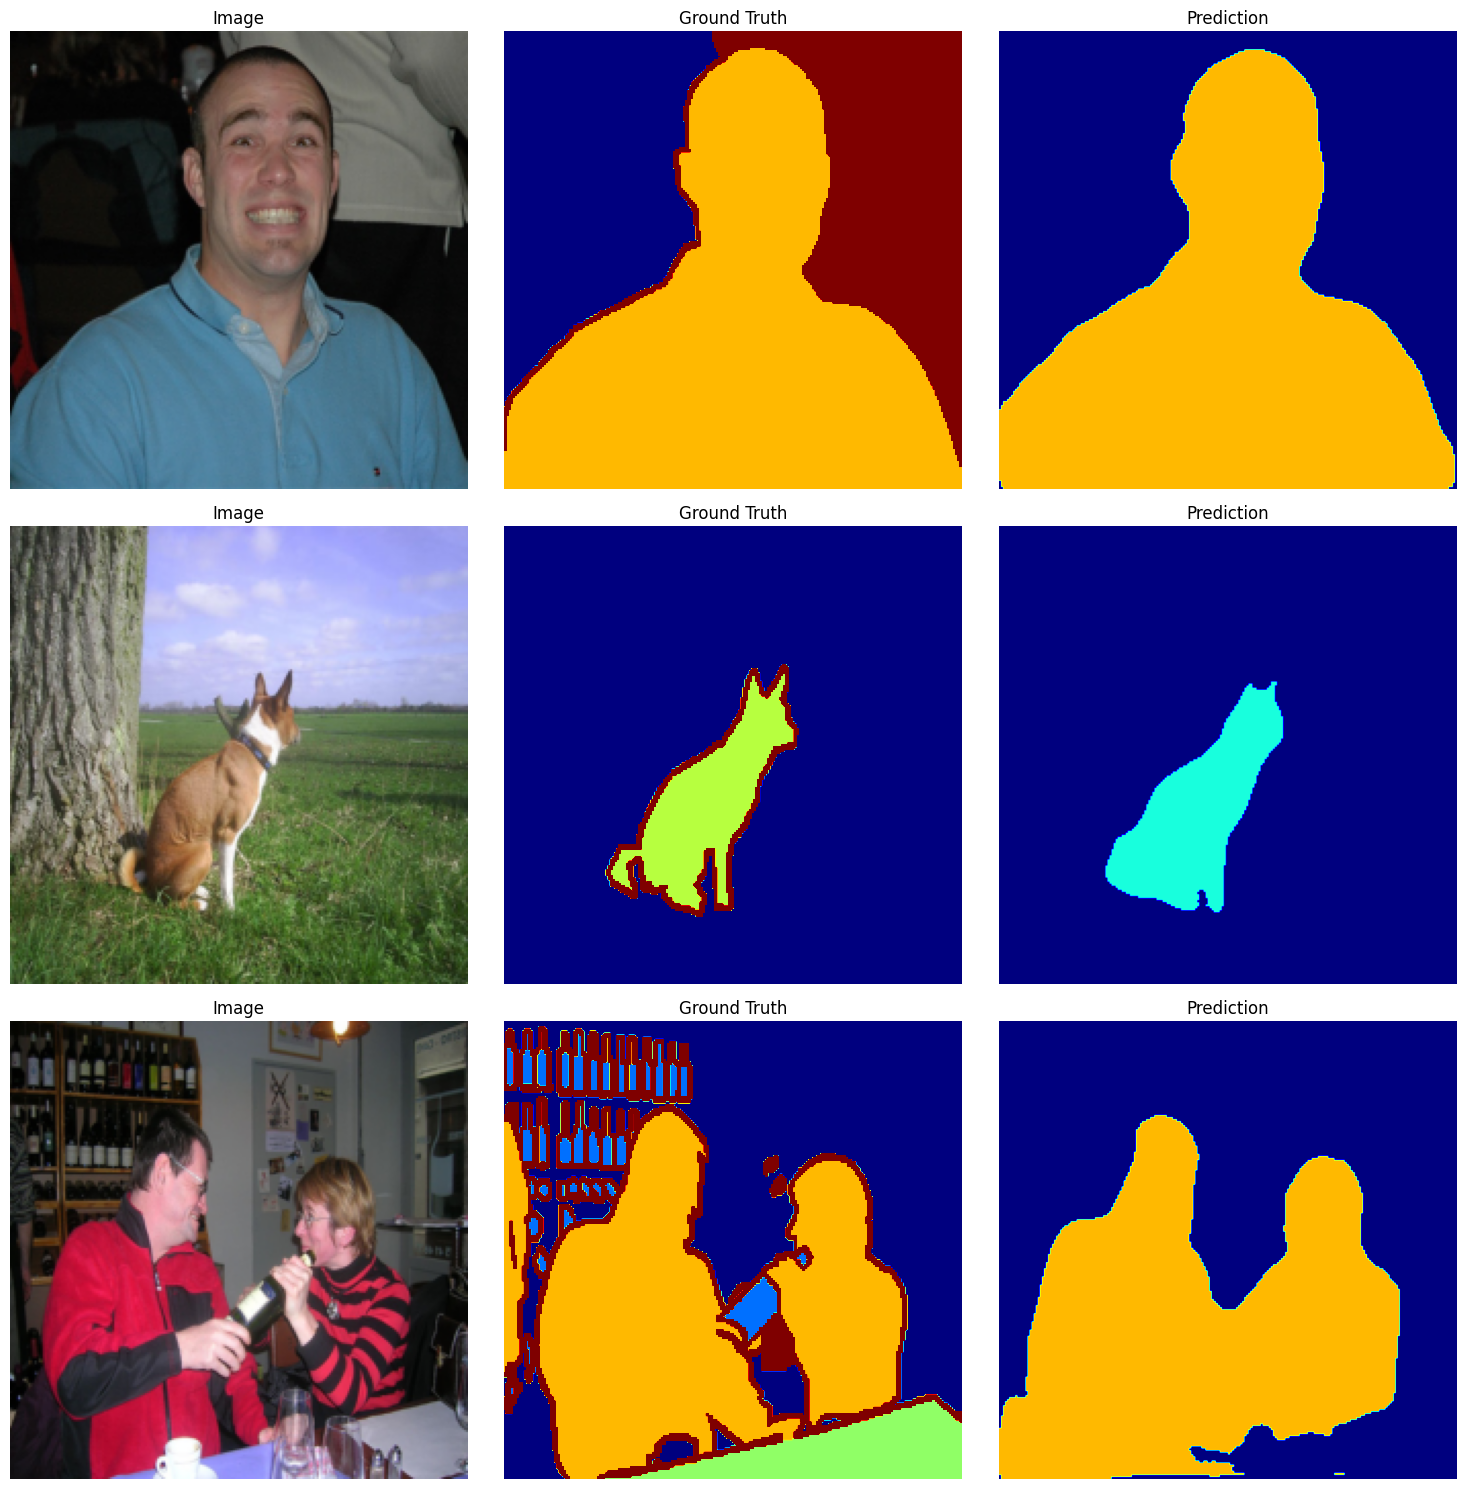

In [62]:
def plot_predictions(model, dataloader, num_samples=3):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Denormalize image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(labels[i].numpy(), cmap="jet", vmin=0, vmax=21)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(preds[i], cmap="jet", vmin=0, vmax=21)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize
plot_predictions(model, val_loader, num_samples=3)

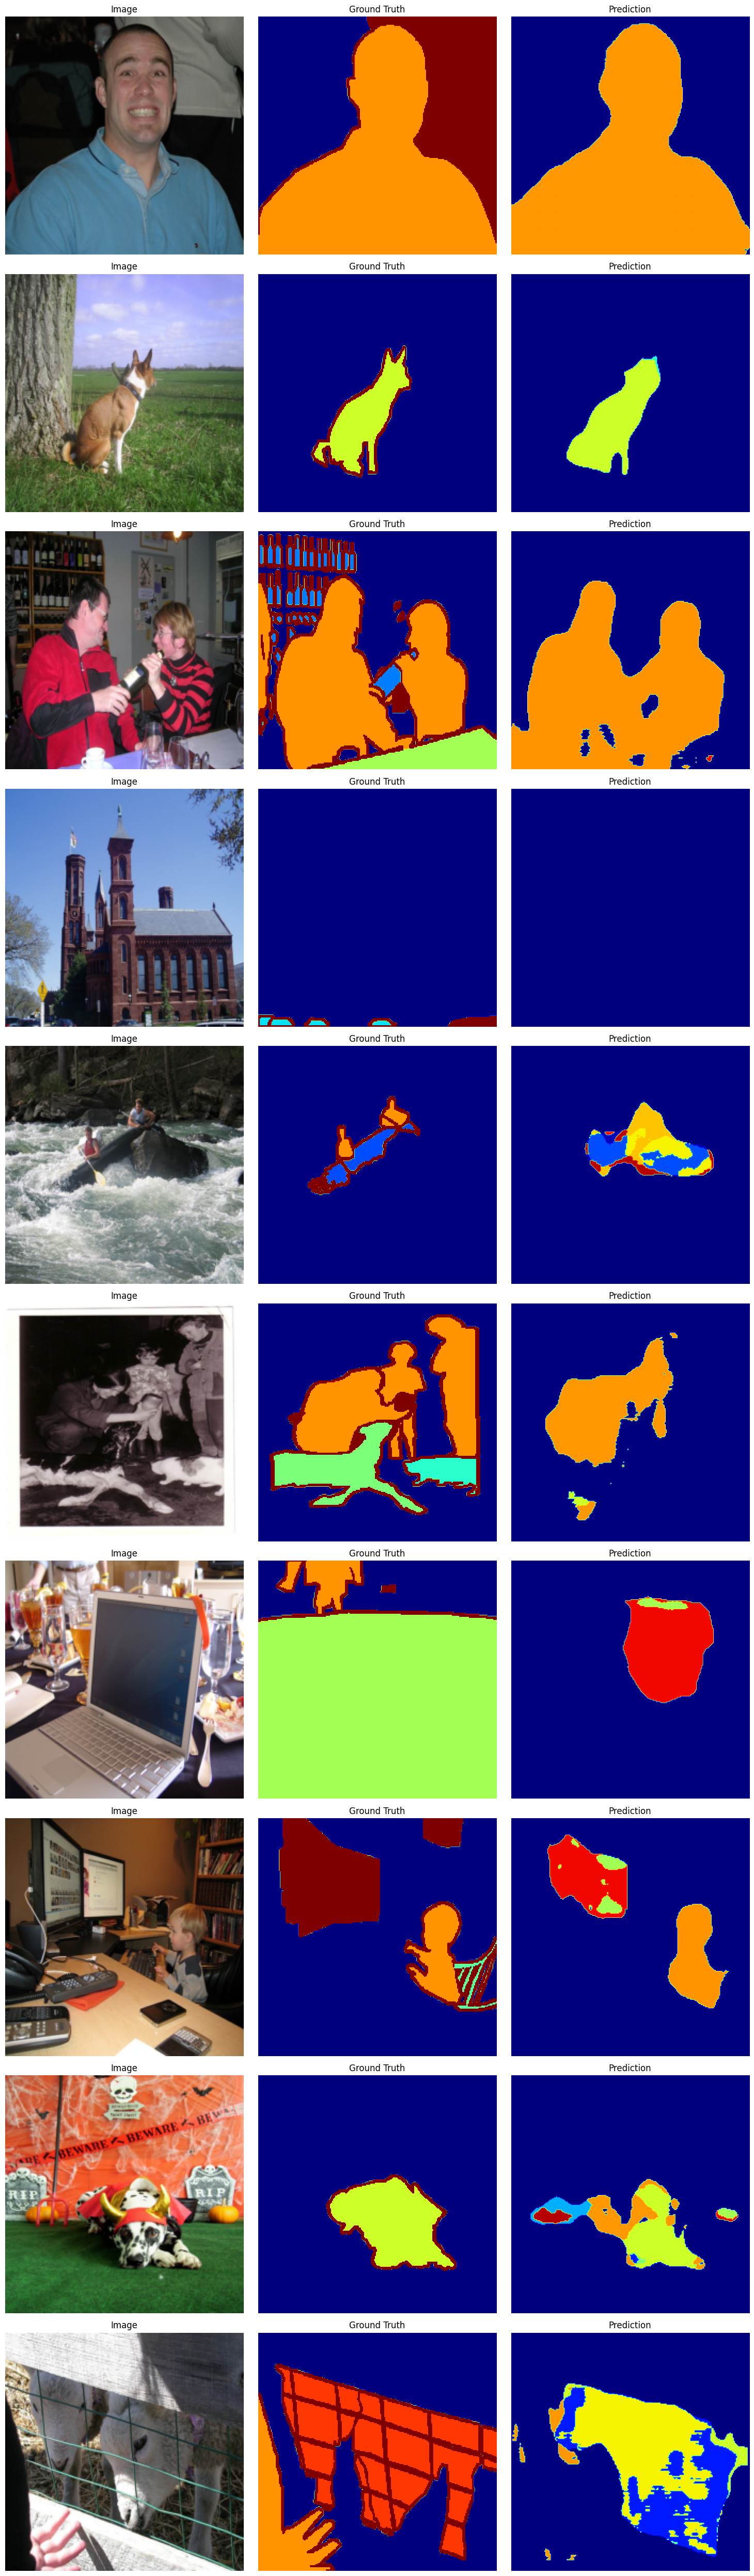

In [29]:
def plot_predictions(model, dataloader, num_samples=10):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Denormalize image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(labels[i].numpy(), cmap="jet", vmin=0, vmax=20)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(preds[i], cmap="jet", vmin=0, vmax=20)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize
plot_predictions(model, val_loader, num_samples=10)


In [42]:
img = Image.open("test/plane7.jpg")

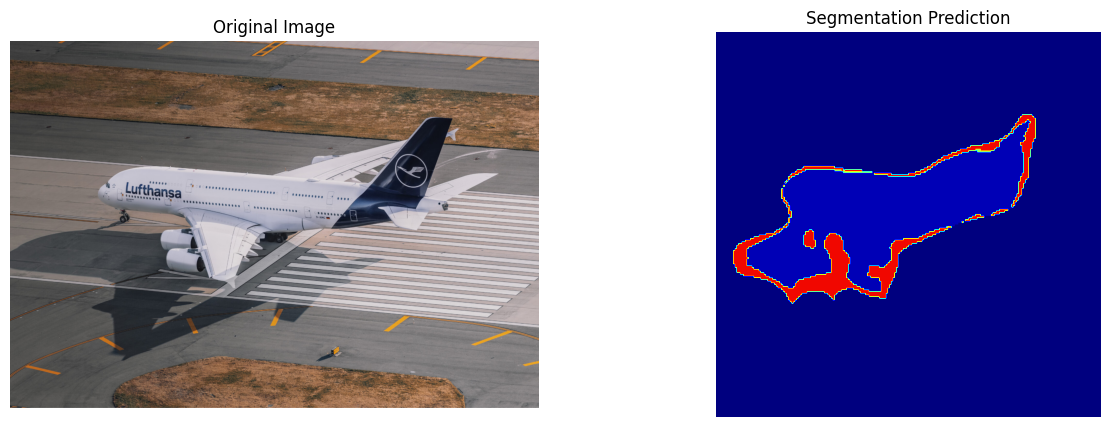

In [43]:
# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Convert PIL image to tensor and add batch dimension
input_tensor = transform(img).unsqueeze(0).to(device)

# Get prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(dim=1).squeeze().cpu().numpy()

# Visualize the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='jet', vmin=0, vmax=20)
plt.title('Segmentation Prediction')
plt.axis('off')
plt.show()